**Kimlik Doğrulama**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Lokalizasyon (Yerelleştirme) İşlemi**

In [ ]:
!mkdir -p drive
!ls

BrainTumor.ipynb  BrainTumorModel.h5  drive  TestOnIslem  TrainOrjinal	veriseti


**Dosya Yerini Belirleme İşlemi**

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Etkinlik2/BrainTumor")
!pwd


/content/drive/MyDrive/Etkinlik2/BrainTumor


**Gerekli Kütüphanelerin Yüklenmesi**

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
#keras
import keras
#from keras.utils import np_utils
import sklearn.metrics as metrics
#Veri Ön İşleme
from os import listdir, mkdir
import imageio
from skimage.transform import resize
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#Eğitim-Test-Geçerleme
import tensorflow as tf
#import keras
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Conv2D
#Grafiklendirme
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd



**Veri Ön İşleme**

In [ ]:
etiketler = listdir("TrainOrjinal")
etiketler.sort()

In [ ]:
import os
import imageio
import numpy as np
from skimage.transform import resize

etiketler = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

# Klasör oluşturma fonksiyonu
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Train
for i, etiket in enumerate(etiketler):
    mkdir("TrainOnIslem" + "/" + etiket)
    etiket_klasoru = "TrainOrjinal" + "/" + etiket
    for resim_adi in os.listdir(etiket_klasoru):
        path = etiket_klasoru + "/" + resim_adi
        resim = imageio.v2.imread(path, mode='F')  # Tek renk kanallı (gri) resim okuma
        resim = resize(resim, (64, 64))  # Yeniden boyutlandırma
        resim = np.stack((resim, resim, resim), axis=-1)  # 3 renk kanalına (RGB) dönüştürme
        resim = (resim * 255).astype(np.uint8)  # uint8 veri tipine dönüştürme
        imageio.v2.imwrite("TrainOnIslem" + "/" + etiket + "/" + resim_adi, resim)


In [ ]:
#Test
for i, etiket in enumerate(etiketler):
    mkdir("TestOnIslem" + "/" + etiket)
    etiket_klasoru = "TestOrjinal" + "/" + etiket
    for resim_adi in listdir(etiket_klasoru):
        path = etiket_klasoru + "/" + resim_adi
        resim = imageio.imread(path, as_gray=True) #as_gray=True:"Gri", as_gray=False:"RGB"
        resim.flatten();
        resim = resize(resim, (64, 64, 1)) #en, boy, kanal:"1:Gri, 3:RGB"
        imageio.imwrite("TestOnIslem" + "/" + etiket + "/" + resim_adi, resim)

**Veri Hazırlama**

In [ ]:
#etiketler = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


In [ ]:
from sklearn.utils import shuffle
from tqdm import tqdm

X, Y = [], []
for i in etiketler:
    folderPath = os.path.join('/content/drive/MyDrive/Etkinlik2/BrainTumor','TestOnIslem',i)
    for resim_adi in tqdm(os.listdir(folderPath)):
        resim = cv2.imread(os.path.join(folderPath,resim_adi))

        resim.flatten();
        resim = resize(resim, (64, 64, 1))
        X.append(resim)
        Y.append(i)

for i in etiketler:
    folderPath = os.path.join('/content/drive/MyDrive/Etkinlik2/BrainTumor','TrainOnIslem',i)
    for resim_adi in tqdm(os.listdir(folderPath)):
        resim = cv2.imread(os.path.join(folderPath,resim_adi))

        resim.flatten();
        resim = resize(resim, (64, 64, 1))
        X.append(resim)
        Y.append(i)

X = np.array(X)
Y = np.array(Y)

100%|██████████| 827/827 [00:03<00:00, 228.02it/s]


In [ ]:

X, Y = shuffle(X,Y, random_state=101)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(etiketler.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(etiketler.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

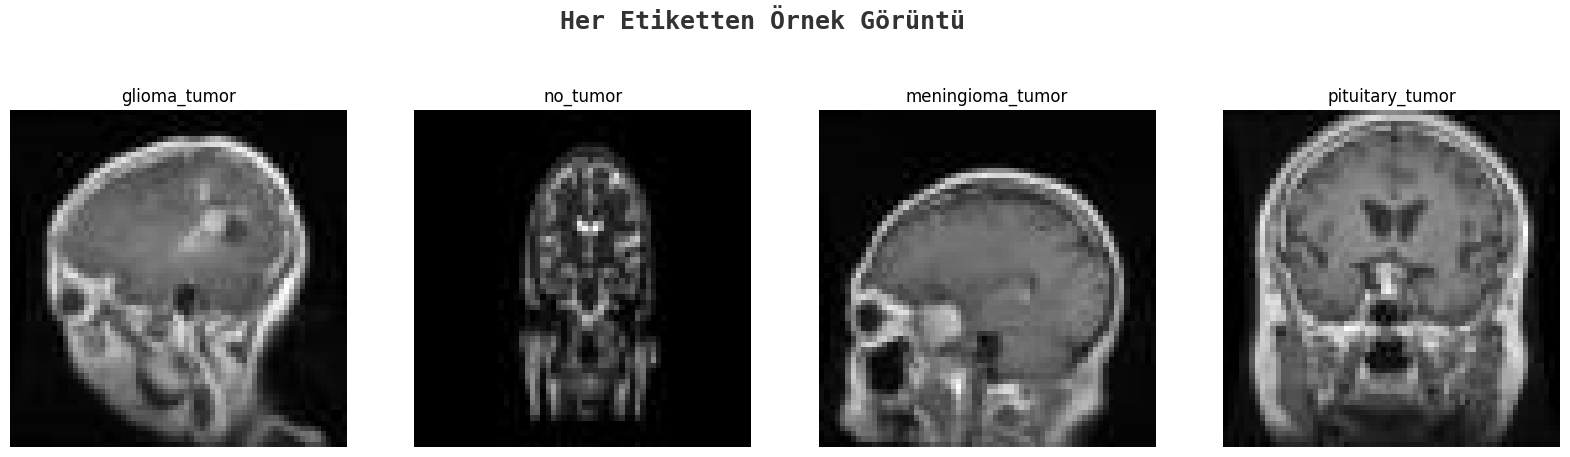

In [ ]:
#Örnek Resimler
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Her Etiketten Örnek Görüntü',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in etiketler:
    j=0
    while True :
        if Y[j]==i:
            ax[k].imshow(X[j],cmap=plt.get_cmap('gray'))
            ax[k].set_title(Y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

**Eğitim-Test**

In [ ]:
keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1))) #en, boy, kanal
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='sigmoid')) #etiketSayisi:2
model.summary()
model.compile(loss=keras.losses.binary_crossentropy,
              #optimizer=tf.keras.optimizers.Adamax(),
              #optimizer=tf.keras.optimizers.RMSprop(),
              #optimizer=tf.keras.optimizers.SGD(lr=0.1),
              optimizer=tf.keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'])
history = model.fit (x_train, y_train,batch_size=32, epochs=20, verbose=1,validation_data=(x_test, y_test))
model.save('BrainTumorModel.h5')
keras.backend.clear_session()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                        

Epoch 1/20
82/82 [==============================] - 79s 950ms/step - loss: 0.5365 - accuracy: 0.3830 - val_loss: 0.4798 - val_accuracy: 0.5115
Epoch 2/20
82/82 [==============================] - 75s 923ms/step - loss: 0.4616 - accuracy: 0.5182 - val_loss: 0.4552 - val_accuracy: 0.5329
Epoch 3/20
82/82 [==============================] - 75s 919ms/step - loss: 0.4029 - accuracy: 0.6013 - val_loss: 0.3554 - val_accuracy: 0.6539
Epoch 4/20
82/82 [==============================] - 75s 916ms/step - loss: 0.3495 - accuracy: 0.6741 - val_loss: 0.3016 - val_accuracy: 0.7289
Epoch 5/20
82/82 [==============================] - 76s 928ms/step - loss: 0.2842 - accuracy: 0.7560 - val_loss: 0.2694 - val_accuracy: 0.7596
Epoch 6/20
82/82 [==============================] - 75s 912ms/step - loss: 0.2392 - accuracy: 0.8058 - val_loss: 0.2184 - val_accuracy: 0.8346
Epoch 7/20
82/82 [==============================] - 75s 912ms/step - loss: 0.1983 - accuracy: 0.8380 - val_loss: 0.1908 - val_accuracy: 0.8377

**Grafiklendirme (Eğitim-Test)**

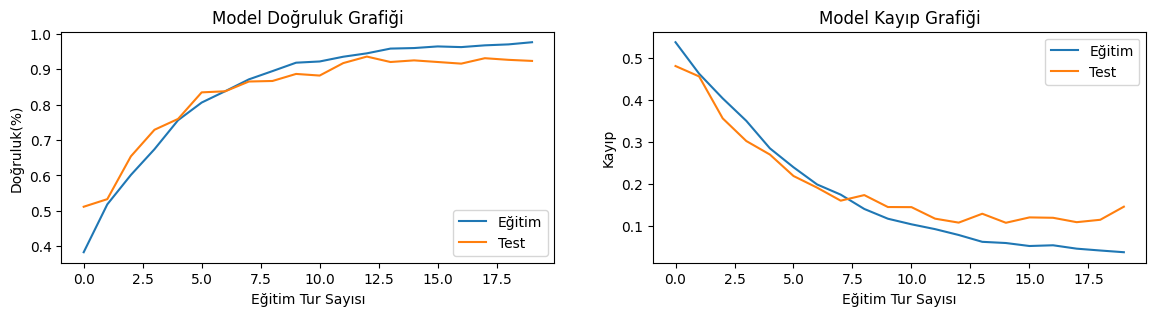

In [ ]:

from matplotlib import pyplot as plt
#Model Doğruluk ve Kayıp Grafikleri
plt.figure(figsize=(14.,3.))
plt.subplots_adjust(hspace=0.4)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Doğruluk Grafiği')
plt.ylabel('Doğruluk(%)')
plt.xlabel('Eğitim Tur Sayısı')
plt.legend(['Eğitim', 'Test'], loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Kayıp Grafiği')
plt.ylabel('Kayıp')
plt.xlabel('Eğitim Tur Sayısı')
plt.legend(['Eğitim', 'Test'], loc='upper right')
plt.show()
